In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import warnings

from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam

Считываю и просматриваю набор данных

In [5]:
dataset, metadata = tfds.load('cycle_gan/summer2winter_yosemite', with_info=True, as_supervised=True)
train_summer = dataset['trainA']
train_winter = dataset['trainB']

In [6]:
# Функция для отображения изображений
def display_images(dataset, class_name, num_images=5):
    plt.figure(figsize=(10, 10))
    for i, (image, _) in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image)
        plt.xlabel(class_name)
    plt.show()

Summer images:


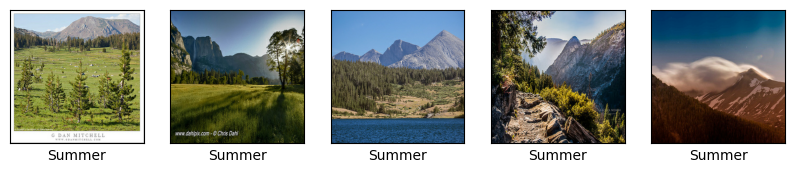

In [7]:
class_names = ['Summer', 'Winter']
print("Summer images:")
display_images(train_summer, class_names[0])

Winter images:


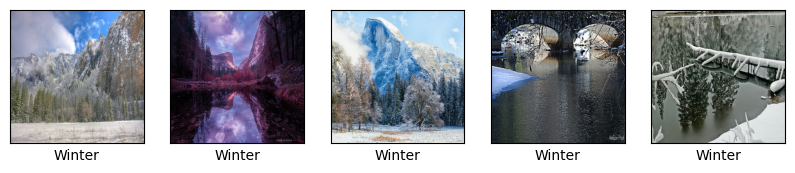

In [8]:
print("Winter images:")
display_images(train_winter, class_names[1])

In [9]:
# Функция для распределения классов и построения гистограммы
def class_distribution_and_plot(datasets, class_names):
    counts = []
    for dataset in datasets:
        count = 0
        for _ in dataset:
            count += 1
        counts.append(count)

    # Построение гистограммы
    plt.figure(figsize=(8, 6))
    plt.bar(class_names, counts, color=['yellow', 'blue'])
    plt.xlabel('Классы')
    plt.ylabel('Количество изображений')
    plt.title('Распределение классов')
    plt.show()

    return counts

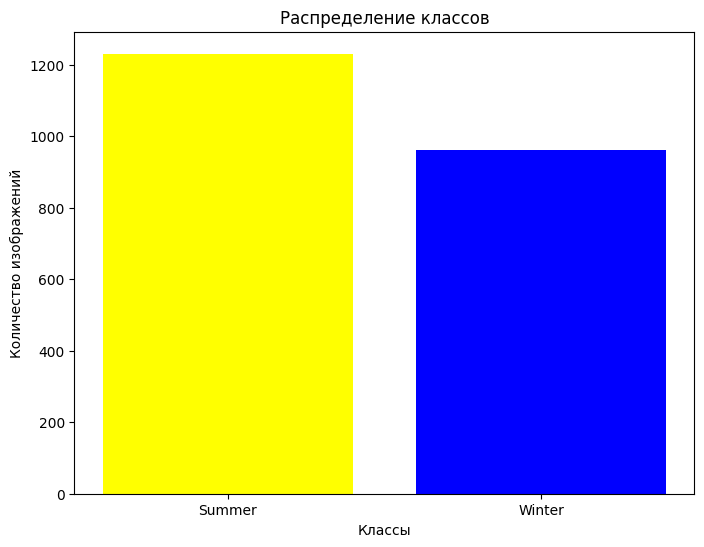

Number of Summer images: 1231
Number of Winter images: 962


In [10]:
class_names = ['Summer', 'Winter']
datasets = [train_summer, train_winter]
counts = class_distribution_and_plot(datasets, class_names)

print(f"Number of Summer images: {counts[0]}")
print(f"Number of Winter images: {counts[1]}")

Летние изображения после предварительной обработки:


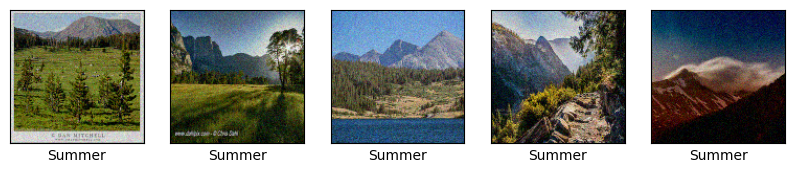

Зимние изображения после предварительной обработки:


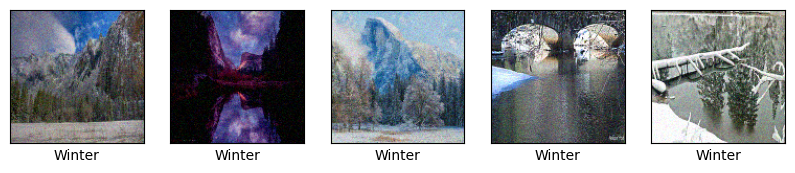

In [13]:
# Добавление меток классам
train_summer = train_summer.map(lambda image, _: (image, 0))
train_winter = train_winter.map(lambda image, _: (image, 1))

# Функция для аугментации изображений
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

# Аугментация изображений
train_summer = train_summer.map(augment)
train_winter = train_winter.map(augment)

# Объединение классов с балансировкой
train_dataset = tf.data.Dataset.sample_from_datasets([train_summer, train_winter], weights=[0.5, 0.5])

# Функция для нормализации и стандартизации размеров изображений
def normalize_and_resize(image, label):
    image = tf.image.resize(image, (128, 128))
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

# Функция для добавления шума
def add_noise(image, label):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=tf.float32)
    image = image + noise
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

# Нормализация и стандартизация размеров
train_summer = train_summer.map(normalize_and_resize)
train_winter = train_winter.map(normalize_and_resize)

# Добавление шума
train_summer = train_summer.map(add_noise)
train_winter = train_winter.map(add_noise)

# Перемешивание данных
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(64)

# Отображение летних изображений
print("Летние изображения после предварительной обработки:")
display_images(train_summer, class_names[0])

# Отображение зимних изображений
print("Зимние изображения после предварительной обработки:")
display_images(train_winter, class_names[1])

In [18]:
# Разделение на обучающую и тестовую выборки
train_size = int(0.8 * (counts[0] + counts[1]))
train_dataset = train_dataset.take(train_size)
test_dataset = train_dataset.skip(train_size)

# Создание модели
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Reshape((-1,)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Обучение модели
steps_per_epoch = train_size // 64
validation_steps = (counts[0] + counts[1] - train_size) // 64
history = model.fit(train_dataset, epochs=5, steps_per_epoch=steps_per_epoch,
                    validation_data=test_dataset, validation_steps=validation_steps)

# Вывод результатов обучения
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node sequential_4_1/reshape_2_1/Reshape defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-18-95674ead764e>", line 28, in <cell line: 28>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 209, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 556, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py", line 66, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/numpy.py", line 4440, in reshape

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/numpy.py", line 1789, in reshape

Input to reshape is a tensor with 7372800 values, but the requested shape has 1605632
	 [[{{node sequential_4_1/reshape_2_1/Reshape}}]] [Op:__inference_one_step_on_iterator_15473]